In [29]:
!pip install koreanize-matplotlib

import matplotlib.pyplot as plt
from matplotlib import rc

# 한글 폰트 설정
rc('font', family='NanumGothic')  # 또는 'Malgun Gothic', 'AppleGothic' 등
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

---
# 종목 선정 과정

- 상관성이 낮은 종목으로 구성
- 단기, 중기, 장기 상관성 비교
- 주식, 채권, 원자재, 금, 달러

<br>

- 장기투자 특성을 고려하여 모든 종목을 ETF로 담음

### 연도별 히트맵 & 상관관계

[*********************100%***********************]  14 of 14 completed


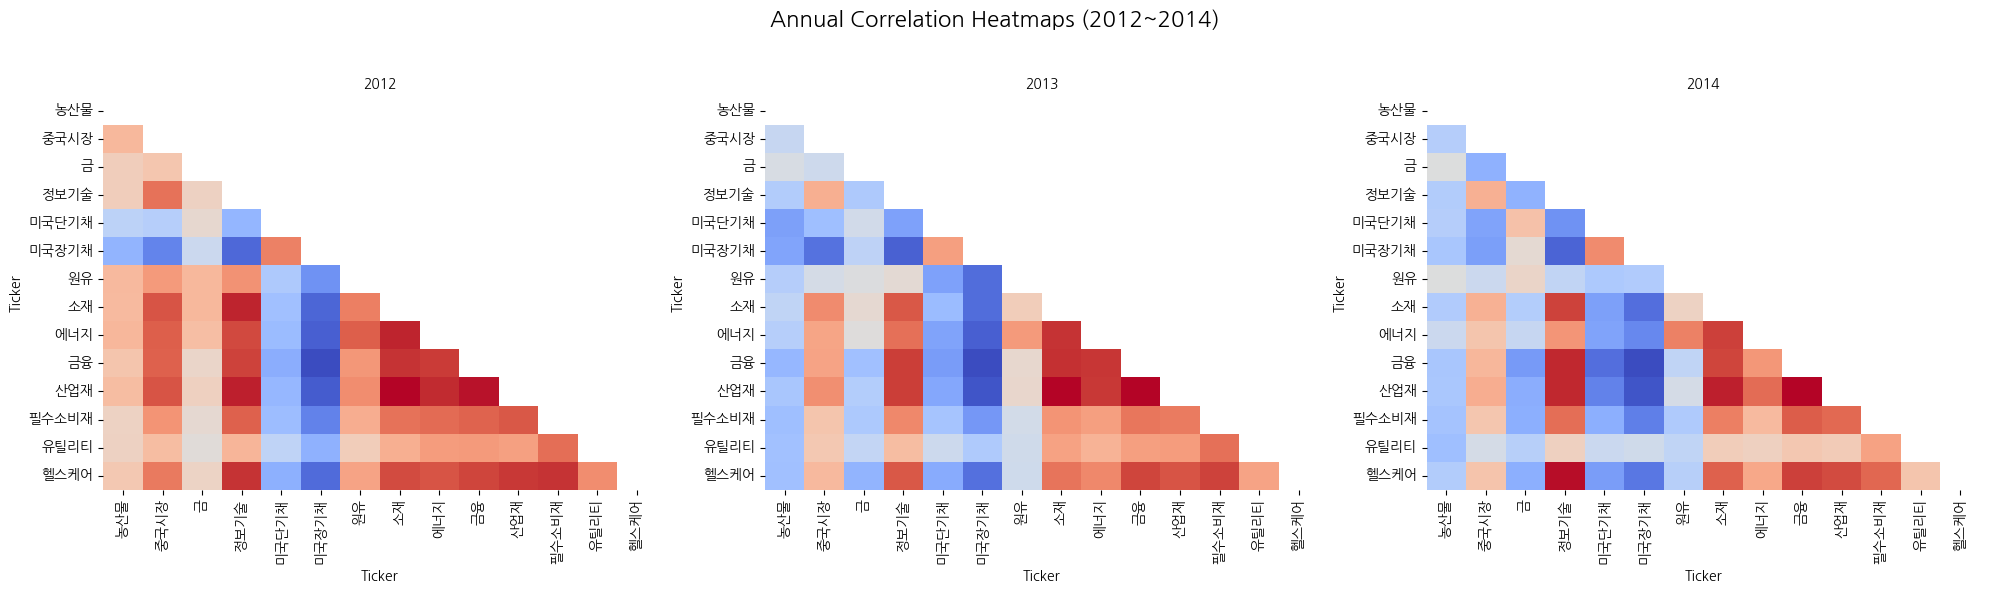

In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 데이터 불러오기
data = pd.read_csv(f'/Users/leesangwon/Downloads/sector(assets).csv', encoding="utf-8")
tickers = data['티커'].tolist()

assets = tickers

# 티커를 섹터(자산군)으로 매핑
ticker_to_name = dict(zip(data['티커'], data['섹터(자산군)']))

# 데이터 다운로드
data = yf.download(assets, start="2012-01-01", end="2015-01-01")['Adj Close']

# prices의 칼럼명(티커)을 "섹터(자산군)"으로 변환
data.rename(columns=ticker_to_name, inplace=True)

# 로그 수익률 계산
log_returns = data.pct_change().apply(lambda x: np.log(1 + x))

# 연도별 상관분석 및 1x3 그리드 시각화
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1행 3열 그리드 생성
fig.suptitle("Annual Correlation Heatmaps (2012~2014)", fontsize=16)

plot_idx = 0  # 플롯 인덱스 초기화
for year in range(2012, 2015):  # 2012~2014년
    # 연도 데이터 필터링
    yearly_data = data[data.index.year == year]
    if yearly_data.empty:  # 데이터가 없는 경우 건너뜀
        print(f"No data for year {year}")
        continue

    # 로그 수익률 계산
    log_returns = yearly_data.pct_change().apply(lambda x: np.log(1 + x)).dropna()  # NaN 제거
    if log_returns.empty:  # 계산된 로그 수익률이 없는 경우 건너뜀
        print(f"No valid log returns for year {year}")
        continue

    # 상관관계 계산
    correlation_matrix = log_returns.corr()

    # 현재 플롯 좌표 계산
    ax = axes[plot_idx]
    plot_idx += 1

    # 상삼각형 마스킹
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # 히트맵 시각화
    sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', fmt=".2f", ax=ax, cbar=False)
    ax.set_title(f"{year}", fontsize=10)

# 남은 플롯 비활성화
for i in range(plot_idx, 3):  # 총 3개의 플롯이므로 남은 플롯 비활성화
    axes[i].axis("off")

# 전체 레이아웃 조정
plt.tight_layout(rect=[0, 0, 1, 0.95])  # 제목 공간 확보
plt.show()

In [3]:
# 상관계수 행렬에서 상관계수가 낮은 항목 추출
low_corr_pairs = []

# 상관계수 행렬 반복
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if np.abs(corr_value) <= 0.2:  # 절댓값 기준
            low_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))

# 데이터프레임 생성 및 정렬
low_corr_assets_ticker = pd.DataFrame(low_corr_pairs, columns=['자산 1', '자산 2', '상관계수'])
low_corr_assets_ticker['상관계수'] = low_corr_assets_ticker['상관계수'].round(2)  # 소수점 2자리 반올림
low_corr_assets_ticker['절댓값'] = np.abs(low_corr_assets_ticker['상관계수'])  # 절댓값 추가
low_corr_df_sorted = low_corr_assets_ticker.sort_values(by='절댓값')  # 절댓값 기준 정렬
low_corr_df_sorted = low_corr_df_sorted.drop(columns=['절댓값'])  # 절댓값 칼럼 삭제

# 상관계수가 낮은 항목 출력
low_corr_df_sorted

,자산 1,자산 2,상관계수
0,농산물,중국시장,0.00
3,농산물,미국단기채,0.00
27,미국장기채,원유,-0.01
21,금,유틸리티,0.01
17,금,소재,-0.01
12,농산물,헬스케어,-0.01
33,원유,헬스케어,0.01
2,농산물,정보기술,-0.01
6,농산물,소재,-0.01
31,원유,필수소비재,-0.02


### 분기별 히트맵 & 상관관계

[*********************100%***********************]  14 of 14 completed


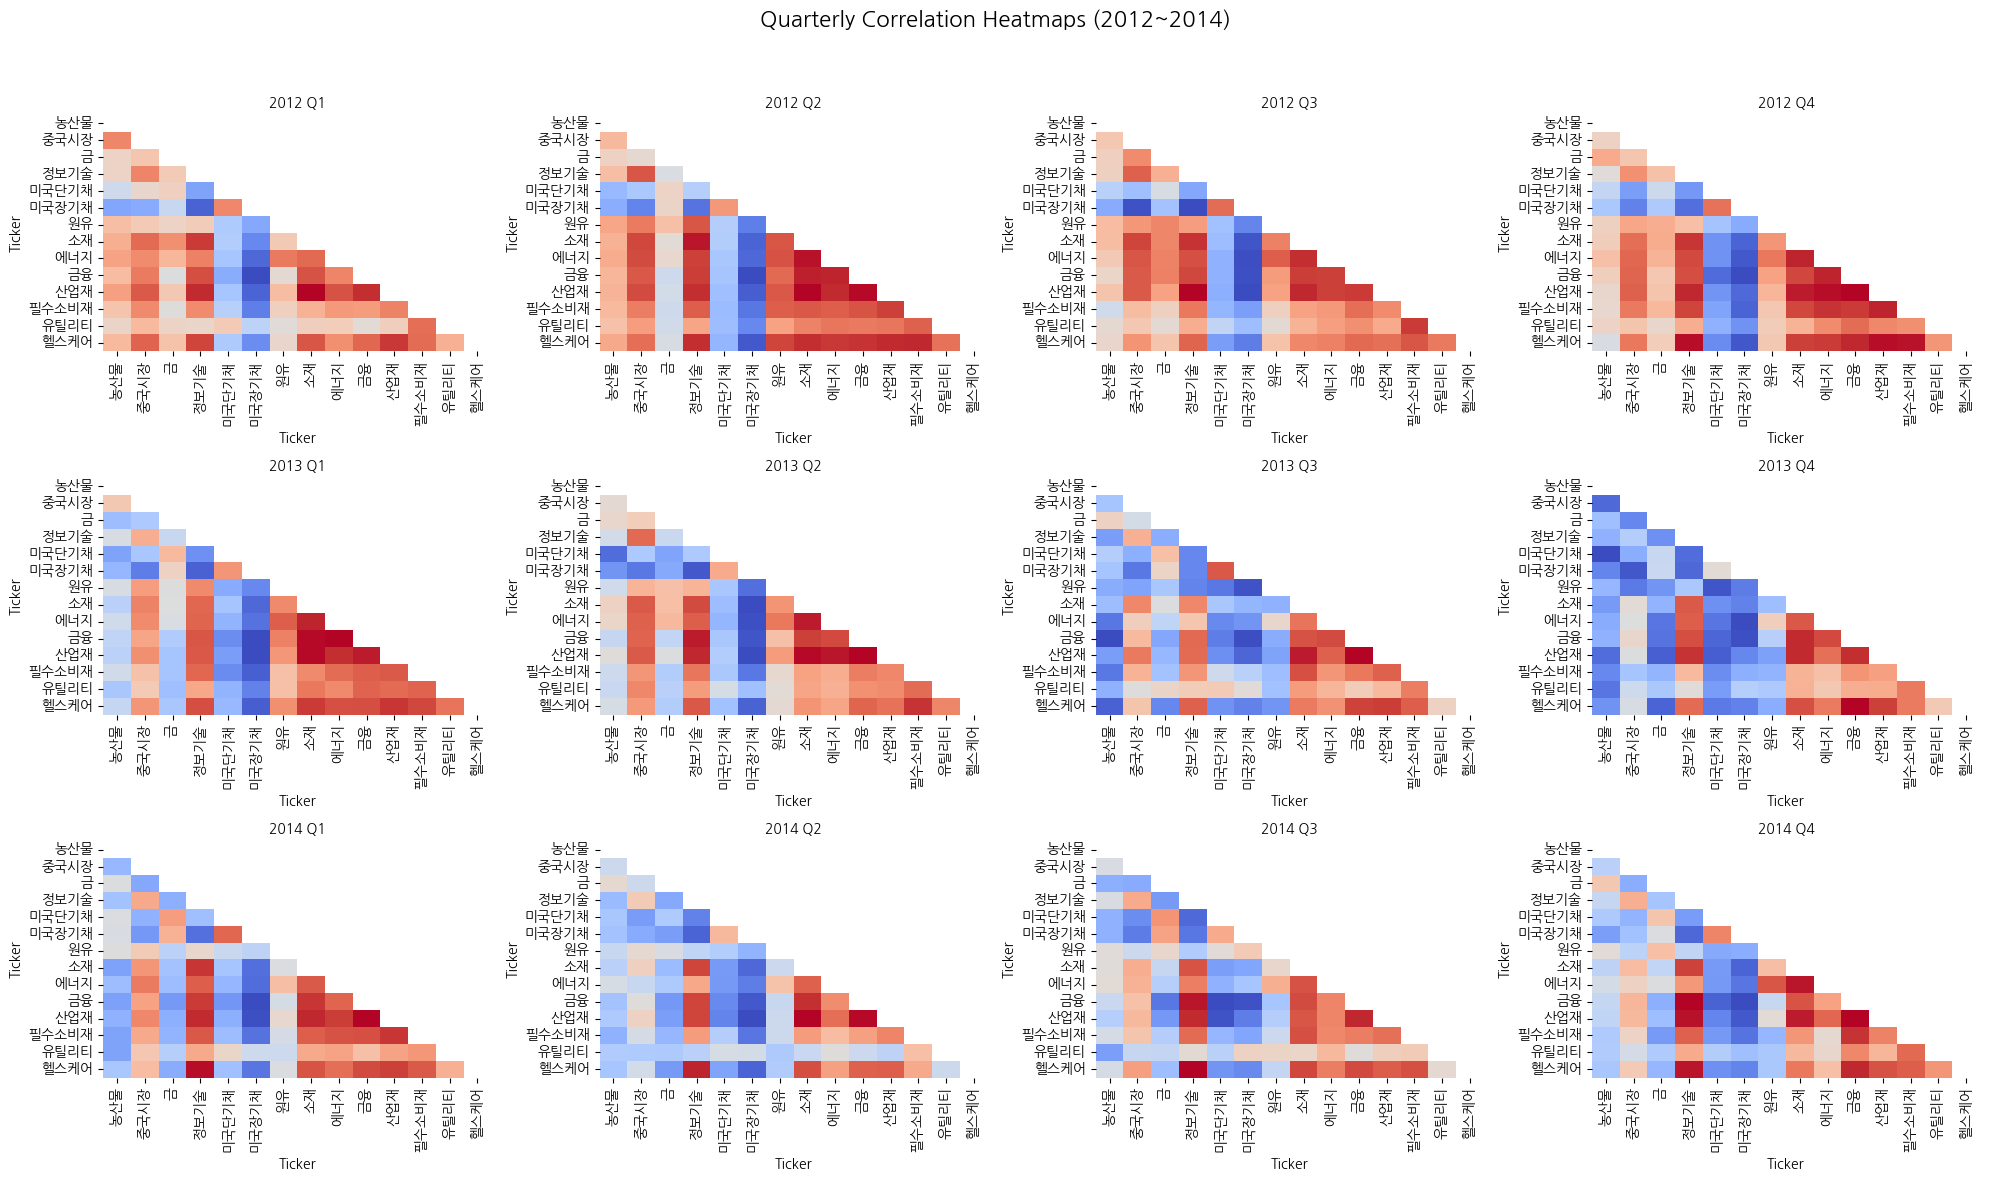

In [4]:
import numpy as np
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 데이터 불러오기
data = pd.read_csv(f'/Users/leesangwon/Downloads/sector(assets).csv', encoding="utf-8")
tickers = data['티커'].tolist()

assets = tickers

# 티커를 섹터(자산군)으로 매핑
ticker_to_name = dict(zip(data['티커'], data['섹터(자산군)']))

# 데이터 다운로드
data = yf.download(assets, start="2012-01-01", end="2015-01-01")['Adj Close']

# prices의 칼럼명(티커)을 "섹터(자산군)"으로 변환
data.rename(columns=ticker_to_name, inplace=True)

# 로그 수익률 계산
log_returns = data.pct_change().apply(lambda x: np.log(1 + x))

# 분기별 상관분석 및 3x4 그리드 시각화
fig, axes = plt.subplots(3, 4, figsize=(20, 12))  # 3행 4열 그리드 생성
fig.suptitle("Quarterly Correlation Heatmaps (2012~2014)", fontsize=16)

plot_idx = 0  # 플롯 인덱스 초기화
for year in range(2012, 2015):
    for quarter in range(1, 5):  # 1~4분기
        # 분기 데이터 필터링
        quarterly_data = data[(data.index.year == year) & (data.index.quarter == quarter)]
        if quarterly_data.empty:  # 데이터가 없는 경우 건너뜀
            continue

        log_returns = quarterly_data.pct_change().apply(lambda x: np.log(1 + x))  # 로그 수익률 계산
        correlation_matrix = log_returns.corr()  # 상관관계 계산
        
        # 현재 플롯 좌표 계산
        row, col = divmod(plot_idx, 4)  # 4열 기준으로 행과 열 결정
        ax = axes[row, col]
        plot_idx += 1

        # 상삼각형 마스킹
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        
        # 히트맵 시각화
        sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', fmt=".2f", ax=ax, cbar=False)
        ax.set_title(f"{year} Q{quarter}", fontsize=10)

# 나머지 빈 플롯 비활성화
for i in range(plot_idx, 12):  # 총 12개의 플롯이므로 남은 플롯 비활성화
    row, col = divmod(i, 4)
    axes[row, col].axis("off")

# 전체 레이아웃 조정
plt.tight_layout(rect=[0, 0, 1, 0.95])  # 제목 공간 확보
plt.show()

In [5]:
# 상관계수 행렬에서 상관계수가 낮은 항목 추출
low_corr_pairs = []

# 상관계수 행렬 반복
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if np.abs(corr_value) <= 0.2:  # 절댓값 기준
            low_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))

# 데이터프레임 생성 및 정렬
low_corr_assets_ticker = pd.DataFrame(low_corr_pairs, columns=['자산 1', '자산 2', '상관계수'])
low_corr_assets_ticker['상관계수'] = low_corr_assets_ticker['상관계수'].round(2)  # 소수점 2자리 반올림
low_corr_assets_ticker['절댓값'] = np.abs(low_corr_assets_ticker['상관계수'])  # 절댓값 추가
low_corr_df_sorted = low_corr_assets_ticker.sort_values(by='절댓값')  # 절댓값 기준 정렬
low_corr_df_sorted = low_corr_df_sorted.drop(columns=['절댓값'])  # 절댓값 칼럼 삭제

# 상관계수가 낮은 항목 출력
low_corr_df_sorted

,자산 1,자산 2,상관계수
26,미국단기채,유틸리티,-0.01
0,농산물,중국시장,0.02
22,금,유틸리티,-0.02
9,농산물,유틸리티,-0.02
4,농산물,소재,0.03
14,중국시장,원유,0.03
8,농산물,필수소비재,-0.03
31,원유,유틸리티,-0.04
32,원유,헬스케어,-0.04
2,농산물,미국단기채,-0.04


---
# 투자 백테스팅

In [73]:
import bt
import quantstats as qs
import pandas as pd
import yfinance as yf
import numpy as np

import koreanize_matplotlib

### 백테스팅 기간 설정

In [74]:
start = '2015-01-01'
end = '2024-11-01'

### 전략 구성

#### bt1. 자산군 마코위츠 최대샤프

[*********************100%***********************]  14 of 14 completed


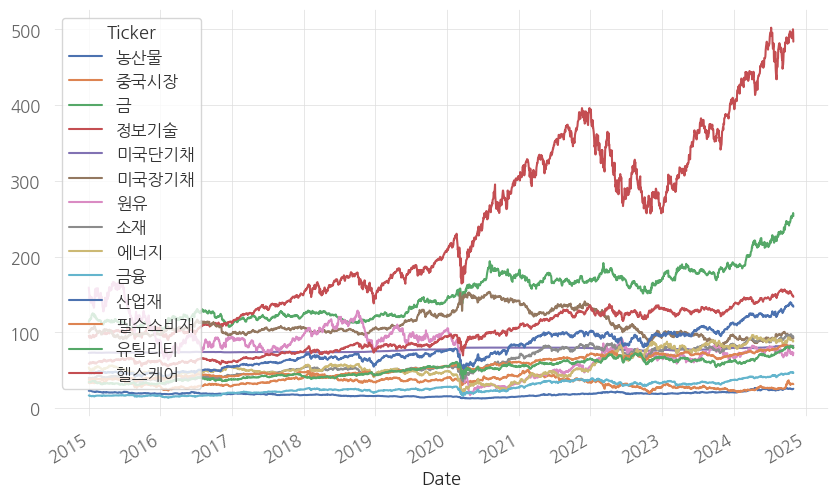

In [75]:
# 데이터 불러오기
data = pd.read_csv(f'/Users/leesangwon/Downloads/sector(assets).csv', encoding="utf-8")
tickers = data['티커'].tolist()

assets = tickers

# 티커를 섹터(자산군)으로 매핑
ticker_to_name = dict(zip(data['티커'], data['섹터(자산군)']))

# 데이터 다운로드
data = yf.download(assets, start=start, end=end)['Adj Close']

# prices의 칼럼명(티커)을 "섹터(자산군)"으로 변환
data.rename(columns=ticker_to_name, inplace=True)

data.plot()

s = bt.Strategy('자산군_마코위츠_최대샤프',
                [bt.algos.RunYearly(run_on_first_date=True,
                                    run_on_end_of_period=True,
                                    run_on_last_date=False),
                 bt.algos.SelectAll(),
                #  bt.algos.WeighEqually(),
                 bt.algos.WeighSpecified(**{
                     '정보기술': 0.0423,
                     '금융': 0.0088,
                     '헬스케어': 0.0446,
                     '산업재': 0.0714,
                     '필수소비재': 0.1682,
                     '에너지': 0.01949,
                     '소재': 0.00065,
                     '유틸리티': 0.0248,
                     '중국시장': 0.0355,
                     '미국장기채': 0.0001,
                     '미국단기채': 0.0902,
                     '금': 0.0137,
                     '원유': 0.1538,
                     '농산물': 0.1451
                     }),            
                 bt.algos.Rebalance()
                 ])

bt1 = bt.Backtest(s, data, initial_capital=10000000)

#### bt2. 자산군 KJH 비율최적화

[*********************100%***********************]  14 of 14 completed


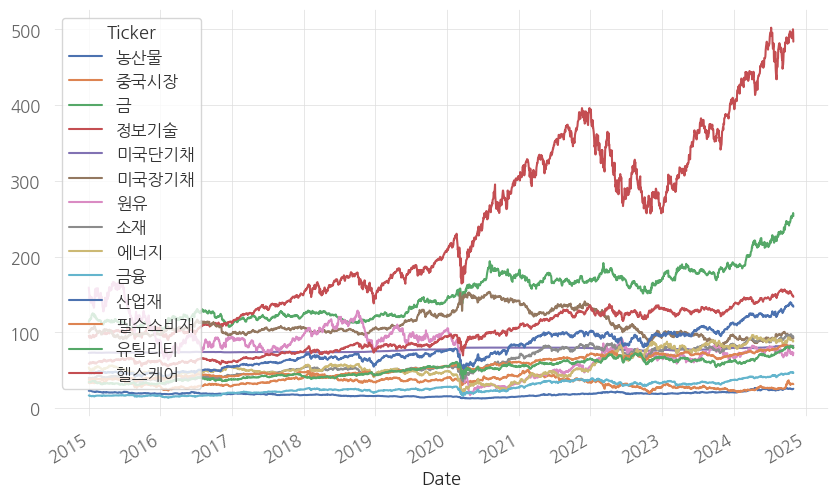

In [76]:
# 데이터 불러오기
data = pd.read_csv(f'/Users/leesangwon/Downloads/sector(assets).csv', encoding="utf-8")
tickers = data['티커'].tolist()

assets = tickers

# 티커를 섹터(자산군)으로 매핑
ticker_to_name = dict(zip(data['티커'], data['섹터(자산군)']))

# 데이터 다운로드
data = yf.download(assets, start=start, end=end)['Adj Close']

# prices의 칼럼명(티커)을 "섹터(자산군)"으로 변환
data.rename(columns=ticker_to_name, inplace=True)

data.plot()

s = bt.Strategy('자산군_KJH_비율최적화',
                [bt.algos.RunYearly(run_on_first_date=True,
                                    run_on_end_of_period=True,
                                    run_on_last_date=False),
                 bt.algos.SelectAll(),
                #  bt.algos.WeighEqually(),
                 bt.algos.WeighSpecified(**{
                     '정보기술': 0.1032,
                     '금융': 0.0587,
                     '헬스케어': 0.0587,
                     '산업재': 0.0587,
                     '필수소비재': 0.0587,
                     '에너지': 0.00587,
                     '소재': 0.0587,
                     '유틸리티': 0.0587,
                     '중국시장': 0.1032,
                     '미국장기채': 0.0992,
                     '미국단기채': 0.0992,
                     '금': 0.0709,
                     '원유': 0.0587,
                     '농산물': 0.0547
                     }),            
                 bt.algos.Rebalance()
                 ])

bt2 = bt.Backtest(s, data, initial_capital=10000000)

#### bt3. 자산군 JTS 비율최적화

[*********************100%***********************]  14 of 14 completed


Momentum Risk Parity Weights: Ticker
농산물      0.047036
중국시장     0.033209
금        0.101538
정보기술     0.085513
미국단기채    0.110084
미국장기채    0.038109
원유       0.000000
소재       0.070130
에너지      0.016230
금융       0.139928
산업재      0.113532
필수소비재    0.081107
유틸리티     0.092530
헬스케어     0.071053
Name: 2024-10-31 00:00:00+00:00, dtype: float64


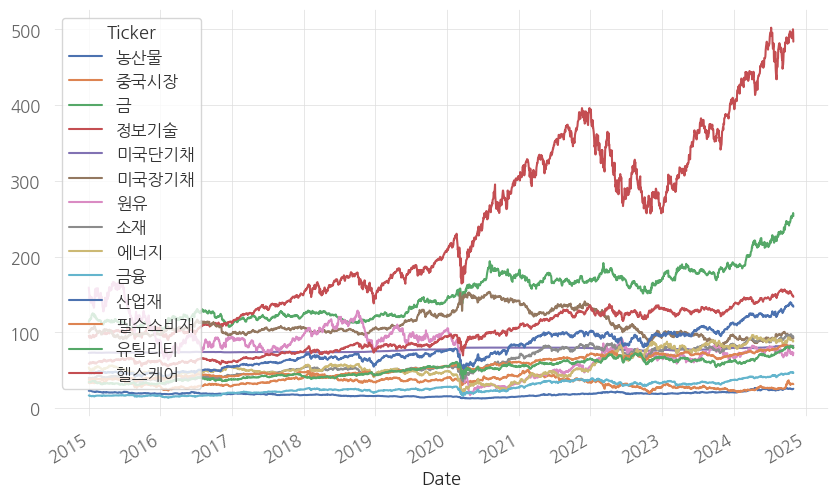

In [77]:
# Momentum Risk Parity 전략

# 데이터 불러오기
data = pd.read_csv(f'/Users/leesangwon/Downloads/sector(assets).csv', encoding="utf-8")
tickers = data['티커'].tolist()

assets = tickers

# 티커를 섹터(자산군)으로 매핑
ticker_to_name = dict(zip(data['티커'], data['섹터(자산군)']))

# 데이터 다운로드
data = yf.download(assets, start=start, end=end)['Adj Close']

# prices의 칼럼명(티커)을 "섹터(자산군)"으로 변환
data.rename(columns=ticker_to_name, inplace=True)

data.plot() ####################################################################################

# 모멘텀 계산: 최근 12개월 수익률
momentum = data.pct_change(252).iloc[-1]  # 252는 1년 거래일 기준

# 변동성 계산: 최근 12개월 표준편차
volatility = data.pct_change().rolling(252).std().iloc[-1]

# 모멘텀 Risk Parity 비중 계산
weights = momentum / volatility  # 모멘텀을 변동성으로 나눔
weights = weights.clip(lower=0)  # 음수 가중치 제거
weights = weights / weights.sum()  # 정규화하여 합이 1로 맞춤

# 비중 출력
print("Momentum Risk Parity Weights:", weights)

# 전략 생성
s = bt.Strategy('자산군_JTS_비율최적화',
                                    [bt.algos.RunYearly(run_on_first_date=True,
                                                        run_on_end_of_period=True,
                                                        run_on_last_date=False),
                                     bt.algos.SelectAll(),
                                     bt.algos.WeighSpecified(**weights.to_dict()),
                                     bt.algos.Rebalance()
                                     ])

bt3 = bt.Backtest(s, data, initial_capital=10000000)

#### bt4. 개별종목 마코위츠 최대샤프

[*********************100%***********************]  5 of 5 completed


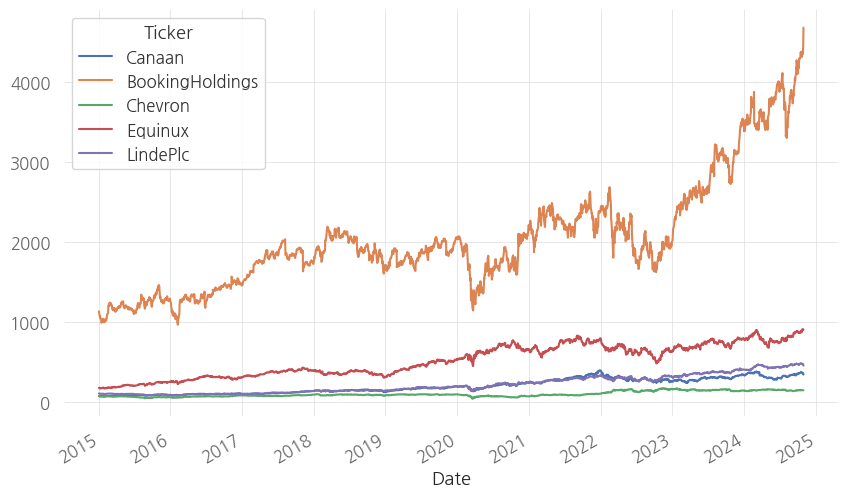

In [78]:
# 데이터 불러오기
data = pd.read_csv(f'/Users/leesangwon/Downloads/sector(assets)_개별종목_호준.csv', encoding="utf-8")
tickers = data['티커'].tolist()

assets = tickers

# 티커를 섹터(자산군)으로 매핑
ticker_to_name = dict(zip(data['티커'], data['섹터(자산군)']))

# 데이터 다운로드
data = yf.download(assets, start=start, end=end)['Adj Close']

# prices의 칼럼명(티커)을 "섹터(자산군)"으로 변환
data.rename(columns=ticker_to_name, inplace=True)

data.plot() ####################################################################################

s = bt.Strategy('개별종목_마코위츠_최대샤프',
                [bt.algos.RunYearly(run_on_first_date=True,
                                    run_on_end_of_period=True,
                                    run_on_last_date=False),
                 bt.algos.SelectAll(),
                #  bt.algos.WeighEqually(),
                 bt.algos.WeighSpecified(**{
                     'BookingHoldings': 0.2192,
                     'LindePlc': 0.0090,
                     'Chevron': 0.0148,
                     'Equinux': 0.7472,
                     'Canaan': 0.0098,
                     }),            
                 bt.algos.Rebalance()
                 ])

bt4 = bt.Backtest(s, data, initial_capital=10000000)

#### bt5. 개별종목 KJH 비율최적화

[*********************100%***********************]  5 of 5 completed


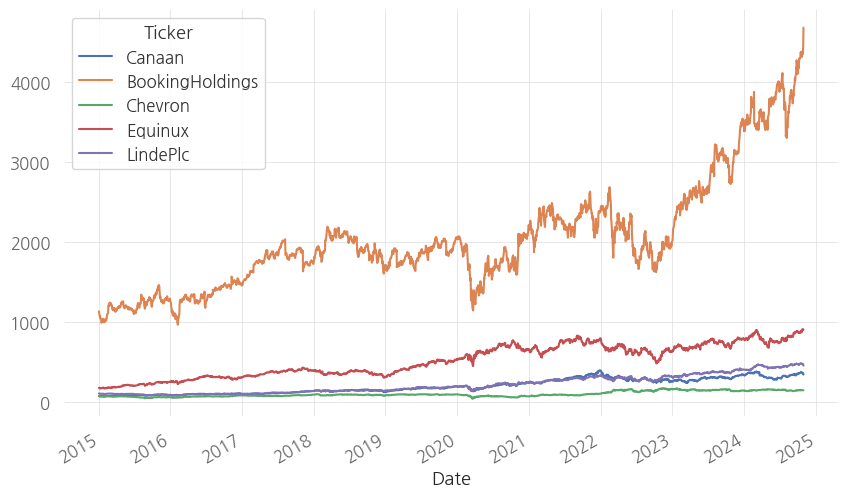

In [89]:
# 데이터 불러오기
data = pd.read_csv(f'/Users/leesangwon/Downloads/sector(assets)_개별종목_호준.csv', encoding="utf-8")
tickers = data['티커'].tolist()

assets = tickers

# 티커를 섹터(자산군)으로 매핑
ticker_to_name = dict(zip(data['티커'], data['섹터(자산군)']))

# 데이터 다운로드
data = yf.download(assets, start=start, end=end)['Adj Close']

# prices의 칼럼명(티커)을 "섹터(자산군)"으로 변환
data.rename(columns=ticker_to_name, inplace=True)

data.plot()

s = bt.Strategy('개별종목_KJH_비율최적화',
                [bt.algos.RunYearly(run_on_first_date=True,
                                    run_on_end_of_period=True,
                                    run_on_last_date=False),
                 bt.algos.SelectAll(),
                #  bt.algos.WeighEqually(),
                 bt.algos.WeighSpecified(**{
                     'BookingHoldings': 0.1555,
                     'LindePlc': 0.0,
                     'Chevron': 0.0,
                     'Equinux': 0.8445,
                     'Canaan': 0.0
                     }),            
                 bt.algos.Rebalance()
                 ])

bt5 = bt.Backtest(s, data, initial_capital=10000000)

#### bt6. 개별종목 JTS 비율최적화

[*********************100%***********************]  5 of 5 completed


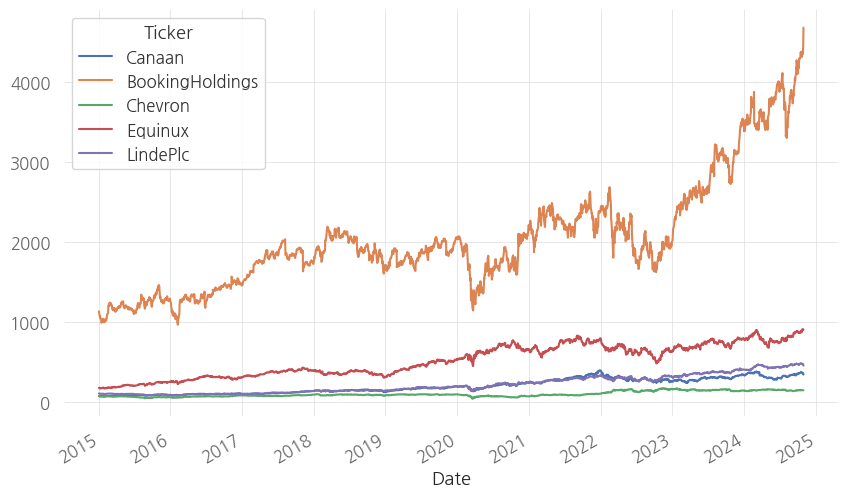

In [80]:
# 데이터 불러오기
data = pd.read_csv(f'/Users/leesangwon/Downloads/sector(assets)_개별종목_호준.csv', encoding="utf-8")
tickers = data['티커'].tolist()

assets = tickers

# 티커를 섹터(자산군)으로 매핑
ticker_to_name = dict(zip(data['티커'], data['섹터(자산군)']))

# 데이터 다운로드
data = yf.download(assets, start=start, end=end)['Adj Close']

# prices의 칼럼명(티커)을 "섹터(자산군)"으로 변환
data.rename(columns=ticker_to_name, inplace=True)

data.plot()

s = bt.Strategy('개별종목_JTS_비율최적화',
                [bt.algos.RunYearly(run_on_first_date=True,
                                    run_on_end_of_period=True,
                                    run_on_last_date=False),
                 bt.algos.SelectAll(),
                #  bt.algos.WeighEqually(),
                 bt.algos.WeighSpecified(**{
                     'BookingHoldings': 0.426892,
                     'LindePlc': 0.215083,
                     'Chevron': 0.055546,
                     'Equinux': 0.178910,
                     'Canaan': 0.123569,
                     }),            
                 bt.algos.Rebalance()
                 ])

bt6 = bt.Backtest(s, data, initial_capital=10000000)

### 벤치마크

#### SPY

In [81]:
# 벤치마크 데이터 불러오기
df = pd.read_csv(f'/Users/leesangwon/Downloads/벤치마크종목.csv', encoding="utf-8")
tickers = df['티커'].tolist()

assets = tickers

# 티커를 섹터(자산군)으로 매핑
ticker_to_name = dict(zip(df['티커'], df['섹터(자산군)']))

# 데이터 다운로드
df = yf.download(assets, start=start, end=end)['Adj Close']

# prices의 칼럼명(티커)을 "섹터(자산군)"으로 변환
df.rename(columns=ticker_to_name, inplace=True)
# df.plot()

# 벤치마크 - 미국시장
def buy_and_hold(df, name='buy_and_hold') :
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, df, initial_capital=10000000)



SPY = buy_and_hold(df['미국시장'].to_frame(), name='SPY')

[*********************100%***********************]  5 of 5 completed


#### All weaether

In [82]:
# 벤치마크 데이터 불러오기
df = pd.read_csv(f'/Users/leesangwon/Downloads/벤치마크종목.csv', encoding="utf-8")
tickers = df['티커'].tolist()

assets = tickers

# 티커를 섹터(자산군)으로 매핑
ticker_to_name = dict(zip(df['티커'], df['섹터(자산군)']))

# 데이터 다운로드
df = yf.download(assets, start=start, end=end)['Adj Close']

# prices의 칼럼명(티커)을 "섹터(자산군)"으로 변환
df.rename(columns=ticker_to_name, inplace=True)
# df.plot()

# 벤치마크 - 올웨더
all_weather = bt.Strategy('All_weather',
                [bt.algos.RunYearly(run_on_first_date=True,
                                    run_on_end_of_period=True,
                                    run_on_last_date=False),
                 bt.algos.SelectAll(),
                 bt.algos.WeighSpecified(**{
                     '미국시장': 0.30,
                     '미국장기채': 0.40,
                     '미국단기채': 0.15,
                     '금': 0.055,
                     '원자재': 0.075
                     }),            
                 bt.algos.Rebalance()
                 ])

all_weather = bt.Backtest(all_weather, df, initial_capital=10000000)

[*********************100%***********************]  5 of 5 completed


#### Permanant

In [83]:
# 벤치마크 데이터 불러오기
df = pd.read_csv(f'/Users/leesangwon/Downloads/벤치마크종목.csv', encoding="utf-8")
tickers = df['티커'].tolist()

assets = tickers

# 티커를 섹터(자산군)으로 매핑
ticker_to_name = dict(zip(df['티커'], df['섹터(자산군)']))

# 데이터 다운로드
df = yf.download(assets, start=start, end=end)['Adj Close']

# prices의 칼럼명(티커)을 "섹터(자산군)"으로 변환
df.rename(columns=ticker_to_name, inplace=True)
# df.plot()

# 벤치마크 - 영구포트폴리오
permanant = bt.Strategy('Permanant',
                [bt.algos.RunYearly(run_on_first_date=True,
                                    run_on_end_of_period=True,
                                    run_on_last_date=False),
                 bt.algos.SelectAll(),
                 bt.algos.WeighSpecified(**{
                     '미국시장': 0.25,
                     '미국장기채': 0.25,
                     '금': 0.25,
                     '원자재': 0.25
                     }),            
                 bt.algos.Rebalance()
                 ])

permanant = bt.Backtest(permanant, df, initial_capital=10000000)

[*********************100%***********************]  5 of 5 completed


### 전략 실행

In [93]:
res = bt.run(SPY, all_weather, permanant, bt1, bt2, bt3, bt4, bt5, bt6)
res.set_riskfree_rate(0.03)

100%|██████████| 9/9 [00:00<00:00, 98.40it/s]


### 결과 분석

<Axes: title={'center': 'Equity Progression'}>

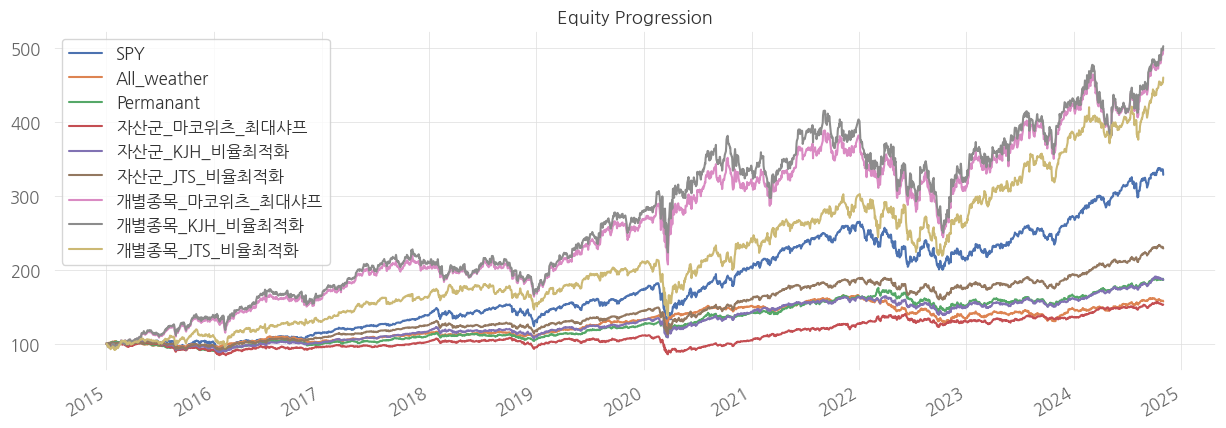

In [94]:
res.plot()

In [95]:
res.display()

Stat                 SPY         All_weather    Permanant    자산군_마코위츠_최대샤프    자산군_KJH_비율최적화    자산군_JTS_비율최적화    개별종목_마코위츠_최대샤프    개별종목_KJH_비율최적화    개별종목_JTS_비율최적화
-------------------  ----------  -------------  -----------  --------------------------  -----------------------  -----------------------  ----------------------------  -------------------------  -------------------------
Start                2015-01-01  2015-01-01     2015-01-01   2015-01-01                  2015-01-01               2015-01-01               2015-01-01                    2015-01-01                 2015-01-01
End                  2024-10-31  2024-10-31     2024-10-31   2024-10-31                  2024-10-31               2024-10-31               2024-10-31                    2024-10-31                 2024-10-31
Risk-free rate       3.00%       3.00%          3.00%        3.00%                       3.00%                    3.00%                    3.00%                         3.00%                      3.00%

<Axes: >

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from current font.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 50997 (\N{HANGUL SYLLABLE YUNG}) missing fro

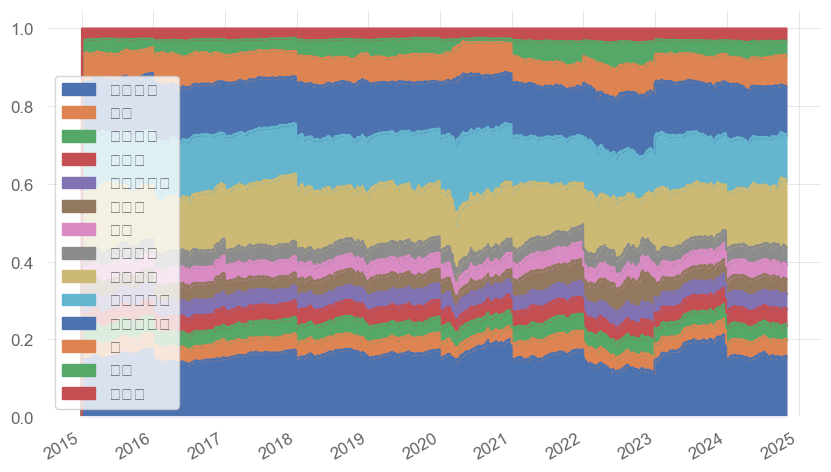

In [ ]:
res.backtests['최초_전략'].security_weights.plot.area()


# 비중조절_재환 어떻게 넣어야할 지 감이 앙잡힌다..

[*********************100%***********************]  14 of 14 completed


Variation -10.00% completed.
Variation -9.50% completed.
Variation -9.00% completed.
Variation -8.50% completed.
Variation -8.00% completed.
Variation -7.50% completed.
Variation -7.00% completed.
Variation -6.50% completed.
Variation -6.00% completed.
Variation -5.50% completed.
Variation -5.00% completed.
Variation -4.50% completed.
Variation -4.00% completed.
Variation -3.50% completed.
Variation -3.00% completed.
Variation -2.50% completed.
Variation -2.00% completed.
Variation -1.50% completed.
Variation -1.00% completed.
Variation -0.50% completed.
Variation 0.00% completed.
Variation 0.50% completed.
Variation 1.00% completed.
Variation 1.50% completed.
Variation 2.00% completed.
Variation 2.50% completed.
Variation 3.00% completed.
Variation 3.50% completed.
Variation 4.00% completed.
Variation 4.50% completed.
Variation 5.00% completed.
Variation 5.50% completed.
Variation 6.00% completed.
Variation 6.50% completed.
Variation 7.00% completed.
Variation 7.50% completed.
Variati

100%|██████████| 52/52 [00:07<00:00,  6.64it/s]


Stat                 Variation_-10.00%    Variation_-9.50%    Variation_-9.00%    Variation_-8.50%    Variation_-8.00%    Variation_-7.50%    Variation_-7.00%    Variation_-6.50%    Variation_-6.00%    Variation_-5.50%    Variation_-5.00%    Variation_-4.50%    Variation_-4.00%    Variation_-3.50%    Variation_-3.00%    Variation_-2.50%    Variation_-2.00%    Variation_-1.50%    Variation_-1.00%    Variation_-0.50%    Variation_0.00%    Variation_0.50%    Variation_1.00%    Variation_1.50%    Variation_2.00%    Variation_2.50%    Variation_3.00%    Variation_3.50%    Variation_4.00%    Variation_4.50%    Variation_5.00%    Variation_5.50%    Variation_6.00%    Variation_6.50%    Variation_7.00%    Variation_7.50%    Variation_8.00%    Variation_8.50%    Variation_9.00%    Variation_9.50%    Variation_10.00%    Variation_10.50%    Random_Variation_1    Random_Variation_2    Random_Variation_3    Random_Variation_4    Random_Variation_5    Random_Variation_6    Random_Variation_7    Rand

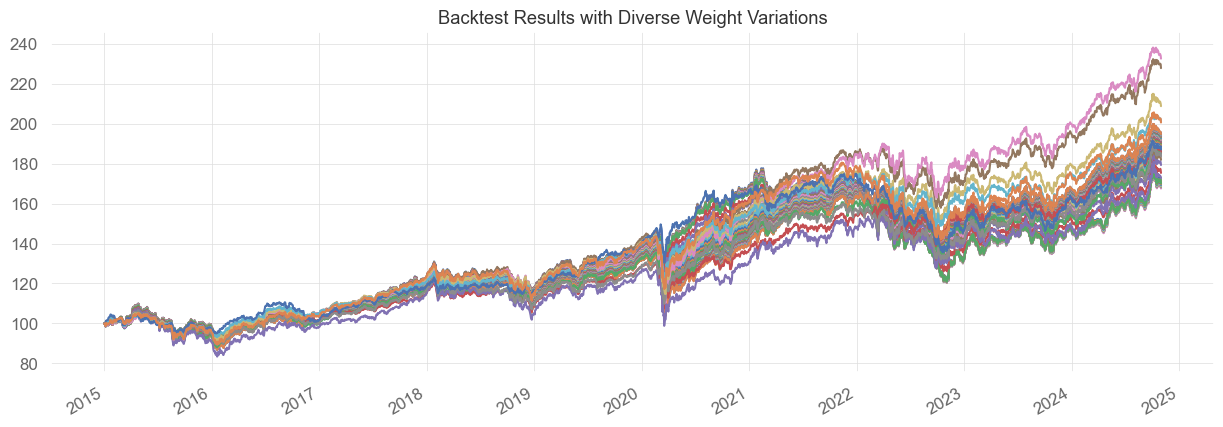

In [ ]:
# 데이터 불러오기
data = pd.read_csv(f'/Users/leesangwon/Downloads/sector(assets).csv', encoding="utf-8")
tickers = data['티커'].tolist()

assets = tickers

# 티커를 섹터(자산군)으로 매핑
ticker_to_name = dict(zip(data['티커'], data['섹터(자산군)']))

# 데이터 다운로드
data = yf.download(assets, start=start, end=end)['Adj Close']

# prices의 칼럼명(티커)을 "섹터(자산군)"으로 변환
data.rename(columns=ticker_to_name, inplace=True)
# data.plot()

####################################################################################

# 초기 전략 비율
initial_weights = {
    '정보기술': 0.15,
    '금융': 0.04,
    '헬스케어': 0.04,
    '산업재': 0.04,
    '필수소비재': 0.04,
    '에너지': 0.04,
    '소재': 0.04,
    '유틸리티': 0.04,
    '중국시장': 0.15,
    '미국장기채': 0.14,
    '미국단기채': 0.14,
    '금': 0.07,
    '원유': 0.04,
    '농산물': 0.03
    }

# 비율 변화 범위 설정
variation_range = np.arange(-0.1, 0.11, 0.005)  # -10% ~ +10%의 변화
random_variations = [np.random.uniform(-0.1, 0.1, len(initial_weights)) for _ in range(10)]  # 랜덤 변화 생성

# 백테스트 결과 저장
backtests = []
random_weights_applied = []  # 랜덤 비율을 저장할 리스트

# 비율 변경 및 백테스팅 실행
for variation in variation_range:
    # 새로운 비율 계산
    modified_weights = {k: max(0, v + variation) for k, v in initial_weights.items()}
    total_weight = sum(modified_weights.values())
    normalized_weights = {k: round(v / total_weight, 4) for k, v in modified_weights.items()}  # 소수점 4자리로 정규화

    # 전략 생성
    s = bt.Strategy(
        f"Variation_{variation:.2%}",
        [
            bt.algos.RunYearly(
                run_on_first_date=True,
                run_on_end_of_period=True,
                run_on_last_date=False
            ),
            bt.algos.SelectAll(),
            bt.algos.WeighSpecified(**normalized_weights),
            bt.algos.Rebalance()
        ]
    )

    # 백테스트 실행
    bt5 = bt.Backtest(s, data, initial_capital=10000000)
    backtests.append(bt5)
    print(f"Variation {variation:.2%} completed.")

# 랜덤 비율 변화 적용
for i, rand_var in enumerate(random_variations):
    # 랜덤 변화 반영
    modified_weights = {k: max(0, v + rand_var[j]) for j, (k, v) in enumerate(initial_weights.items())}
    total_weight = sum(modified_weights.values())
    normalized_weights = {k: round(v / total_weight, 4) for k, v in modified_weights.items()}  # 소수점 4자리로 제한

    # 랜덤 비율 저장
    random_weights_applied.append(normalized_weights)

    # 전략 생성
    s = bt.Strategy(
        f"Random_Variation_{i+1}",
        [
            bt.algos.RunYearly(
                run_on_first_date=True,
                run_on_end_of_period=True,
                run_on_last_date=False
            ),
            bt.algos.SelectAll(),
            bt.algos.WeighSpecified(**normalized_weights),
            bt.algos.Rebalance()
        ]
    )

    # 백테스트 실행
    bt5 = bt.Backtest(s, data, initial_capital=10000000)
    backtests.append(bt5)
    print(f"Random Variation {i+1} completed.")

# 모든 백테스트 실행
res = bt.run(*backtests)

# 결과 표시
res.display()

# 각 백테스트 결과 정리
results_summary = []
strategy_weights = {}

for bt_test in res.backtests.values():
    total_return = bt_test.stats.total_return
    max_drawdown = bt_test.stats.max_drawdown
    daily_sharpe = bt_test.stats.daily_sharpe
    strategy_name = bt_test.name

    # 백테스트 전략 이름과 대응하는 가중치를 저장
    strategy_weights[strategy_name] = bt_test.strategy.weight

    results_summary.append({
        'Strategy': strategy_name,
        'Total Return (%)': total_return * 100,
        'Max Drawdown (%)': max_drawdown * 100,
        'Daily Sharpe': daily_sharpe
    })

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results_summary)

# 최적의 전략 찾기
best_strategy_row = results_df.sort_values(
    by=['Total Return (%)', 'Daily Sharpe', 'Max Drawdown (%)'],
    ascending=[False, False, True]
).iloc[0]

best_strategy_name = best_strategy_row['Strategy']
best_strategy_weights = strategy_weights[best_strategy_name]

# 최적의 전략과 가중치 출력
print("\nBest Strategy Based on Metrics:")
print(best_strategy_row)
print("\nBest Strategy Weights:")
print(best_strategy_weights)

# 랜덤 비율 출력
print("\nRandom Weight Variations Applied:")
for i, weights in enumerate(random_weights_applied):
    print(f"Random Variation {i+1}: {weights}")

# 결과 테이블 출력
print("\nAll Strategy Results:")
print(results_df)

# 결과 시각화
res.plot(title="Backtest Results with Diverse Weight Variations")
plt.legend().remove()